In [1]:
import gzip
import joblib
import pandas
import pickle
import seaborn
import tqdm

from lib.models.generic_v0.model import map_params

In [2]:
import sys

util_dir = "./sprint-0-explicit-mdps/"
sys.path.append(util_dir)

import util

In [3]:
fixed_dag_size = pandas.read_pickle(
    "5-generated-mdps/fixed.pkl.gz"
).dag_size_limit.drop_duplicates()
assert len(fixed_dag_size) == 1
fixed_dag_size = fixed_dag_size.iloc[0]
fixed_dag_size

4

In [4]:
mdps = pandas.read_pickle("5-generated-mdps/success.pkl.gz")
mdps

max_dag_size = mdps.query(
    'problem == "v1+fc+n" and protocol == "bitcoin"'
).dag_size_limit.max()
max_dag_size

biggest_v1 = mdps.query(
    f'problem == "v1+fc+n" and protocol == "bitcoin" and dag_size_limit <= {max_dag_size}'
)
biggest_v1


ref_models = mdps.query(
    f'problem.str.startswith("ref") and dag_size_limit <= {max_dag_size}'
)
ref_models

mdps = pandas.concat([biggest_v1, ref_models])

In [5]:
networks = []
# for alpha in range(5, 46, 5):
for alpha in [33]:
    for gamma in [0.33, 0.66]:
        # for gamma in [0, 0.5, 1]:
        networks.append(dict(alpha=alpha / 100, gamma=gamma))
# pandas.DataFrame(networks)

In [6]:
horizon = 100
stop_delta = (
    0.0001  # value iteration stops when no value estimate changes more than this value
)

In [7]:
def optimize(network, idx, row):
    with gzip.open(f"5-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
        emdp = pickle.load(f)
        emdp = map_params(emdp, **network)
        oae = util.optimize_and_evaluate(emdp, eps=stop_delta, horizon=horizon)
        return row.to_dict() | dict(horizon=horizon) | network | oae


def generate_jobs():
    for network in networks:
        for idx, row in mdps.iterrows():
            # if row['size'] > 1000:
            #    continue
            yield joblib.delayed(optimize)(network, idx, row)


jobs = list(generate_jobs())
generate_solutions = joblib.Parallel(return_as="generator_unordered", n_jobs=6)(jobs)
with_progress = tqdm.tqdm(generate_solutions, total=len(jobs))
df = pandas.DataFrame(with_progress)
df.to_pickle("6-value-iterations.pkl.gz")
df

  0%|                                                                                                                                                             | 0/42 [00:00<?, ?it/s]

  2%|███▌                                                                                                                                                 | 1/42 [00:00<00:21,  1.90it/s]

  5%|███████                                                                                                                                              | 2/42 [00:00<00:13,  3.03it/s]

 12%|█████████████████▋                                                                                                                                   | 5/42 [00:00<00:05,  7.16it/s]

 17%|████████████████████████▊                                                                                                                            | 7/42 [00:01<00:03,  8.94it/s]

 21%|███████████████████████████████▉                                                                                                                     | 9/42 [00:01<00:05,  5.55it/s]

 29%|██████████████████████████████████████████▎                                                                                                         | 12/42 [00:01<00:04,  7.33it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                  | 14/42 [00:02<00:03,  8.03it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                           | 16/42 [00:02<00:02,  8.95it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                    | 18/42 [00:02<00:02, 10.18it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                             | 20/42 [00:02<00:02,  8.64it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                      | 22/42 [00:03<00:03,  5.23it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████                                                                   | 23/42 [00:03<00:04,  4.34it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                            | 25/42 [00:04<00:03,  5.49it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 26/42 [00:04<00:05,  3.11it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 28/42 [00:05<00:03,  4.29it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 29/42 [00:05<00:04,  3.12it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 32/42 [00:06<00:02,  4.54it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 33/42 [00:06<00:01,  4.61it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 35/42 [00:06<00:01,  5.37it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 36/42 [00:06<00:01,  5.34it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 37/42 [00:06<00:00,  5.63it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 38/42 [00:07<00:00,  4.66it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 39/42 [00:08<00:01,  2.66it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 40/42 [00:11<00:02,  1.18s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 41/42 [00:18<00:02,  2.86s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:21<00:00,  2.95s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:21<00:00,  1.92it/s]

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,...,vi_time,vi_max_value,ss_reachable,ss_nonzero,ss_time,pe_iter,ptrev,rpp,time,vi_steady_value
0,v1+fc+n,generic-v1,True,True,True,True,True,bitcoin,2,5,...,0.052058,33.323488,4,4,0.058600,2,0.163350,0.330000,0.110992,32.660188
1,v1+fc+n,generic-v1,True,True,True,True,True,bitcoin,3,18,...,0.190020,33.970353,6,4,0.056300,2,0.163350,0.330000,0.247006,32.660188
2,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,2,3,...,0.029605,33.323488,3,3,0.001199,2,0.326700,0.330000,0.031021,32.660188
3,v1+fc+n,generic-v1,True,True,True,True,True,bitcoin,4,45,...,0.342363,34.600949,6,4,0.054085,2,0.163350,0.330000,0.397663,32.660188
4,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,4,18,...,0.140539,35.364783,9,9,0.001220,2,0.267259,0.336973,0.142442,33.394970
5,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,2,3,...,0.026091,33.323488,3,3,0.000858,2,0.163350,0.330000,0.027076,32.660139
6,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,4,15,...,0.110051,35.355691,10,10,0.001015,2,0.153256,0.336973,0.111440,33.306105
7,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,8,90,...,0.792133,40.772717,37,37,0.001538,2,0.269924,0.355041,0.797038,35.265194
8,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,8,69,...,0.585442,40.346378,28,28,0.001302,2,0.157278,0.353519,0.588079,34.972266
9,v1+fc+n,generic-v1,True,True,True,True,True,bitcoin,5,120,...,1.027690,35.683087,19,19,0.054656,2,0.132453,0.337361,1.085810,33.430280


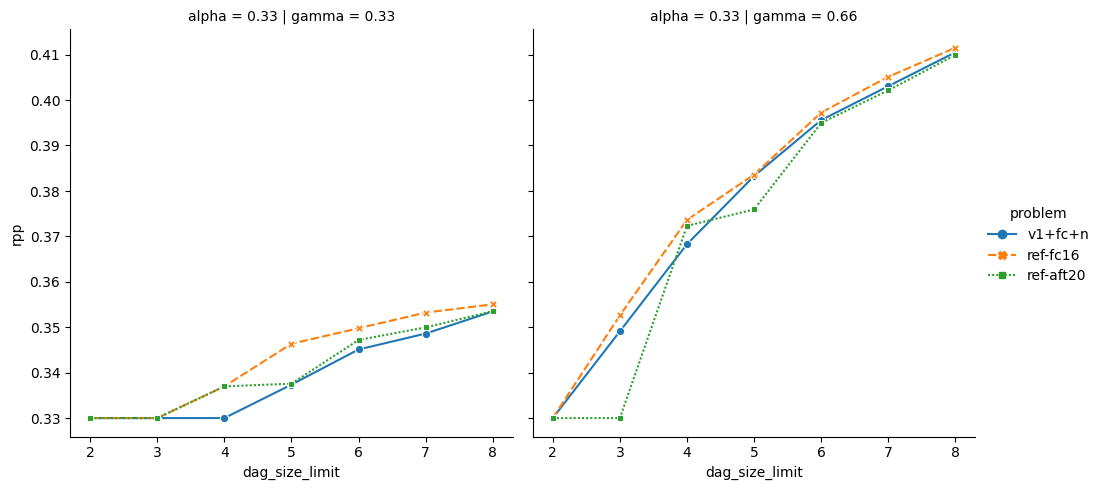

In [8]:
seaborn.relplot(
    data=df,
    kind="line",
    x="dag_size_limit",
    y="rpp",
    hue="problem",
    style="problem",
    markers=True,
    col="gamma",
    row="alpha",
)

In [9]:
!rm -f 6-bitcoin-rpp-for-dag-size-alpha*-gamma*.csv

In [10]:
for alpha in df.alpha.drop_duplicates():
    for gamma in df.gamma.drop_duplicates():
        fname = f"6-bitcoin-rpp-for-dag-size-alpha{str(alpha)[2:]}-gamma{str(gamma)[2:]}.csv"
        sdf = df.query(f"alpha == {alpha} and gamma == {gamma}")[
            ["problem", "dag_size_limit", "rpp"]
        ]
        sdf = sdf.pivot(index="dag_size_limit", columns="problem", values="rpp")
        sdf.to_csv(fname)
sdf

problem,ref-aft20,ref-fc16,v1+fc+n
dag_size_limit,,,
2,0.330000,0.330000,0.330000
3,0.330000,0.352596,0.349084
4,0.372304,0.373609,0.368257
5,0.375918,0.383576,0.383257
6,0.394942,0.397233,0.395573
7,0.402120,0.405106,0.403036
8,0.409916,0.411505,0.410498


In [11]:
!ls 6-bitcoin-rpp-for-dag-size-alpha*-gamma*.csv

6-bitcoin-rpp-for-dag-size-alpha33-gamma33.csv
6-bitcoin-rpp-for-dag-size-alpha33-gamma66.csv
